# Programming Exercise 4: Hidden Markov Model

## 0. Background introduction:

The biologging technology is revolutionizing researchers' ability to study animal behavior. Using sensors i.e.accelerometers, magnetometers, global positioning systems (GPS), and cameras, researchers gather data and analyze them with tools such as the Hidden Markov Model (HMM), thus understanding animals' behavior and contributing to conservation management. In this exercise, you will build the transition model and sensor model in HMM with obtained data, and implement filtering, smoothing, prediction, and Viterbi algorithm to analyze the flying behavior of the **albatross**.

Albatrosses are known for their ability to travel vast distances with low energetic costs using a specialized form of flight –**dynamic soaring**– by exploiting energy from wind and waves. Despite this specialization, albatrosses also use powered flight in the form of **flapping** when necessary, such as in light wind conditions. Given the large differences in body kinematics associated with flapping and soaring flight, we hypothesized that HMMs would be able to effectively distinguish between these two flight modes as well as identify when birds were sitting **on water**

<img src="data/albatrosse.png">

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
<font size=2>https://www.nationalgeographic.com/animals/birds/facts/albatrosses</font>

If you want to know more about the biologging technology, please read [this paper](https://esajournals.onlinelibrary.wiley.com/doi/full/10.1890/14-1401.1)

<div class="alert alert-info">
    <h3>Please read the following important information before starting with the programming exercise: </h3>
    <p>You should try to complete the missing code. Please make sure that all functions follow the provided interfaces and that the return value of the function exactly matches the descriptions in the code comments. You only need to modify code within blocks like the following. Adding or modifying the code outside comment blocks is not required.</p>
</div>

In [ ]:
##########################################################
# YOUR CODE HERE

##########################################################


<div class="alert alert-info">
    <p>For testing and grading purposes, it is important to note that <b>you are not allowed to import any additional libraries</b>, and the <b>structure of the provided functions (i.e. the arguments and names) should not be changed</b>. Additionally, please make sure <b>not to use any other libraries except numpy</b> to implement, otherwise, you will be considered cheating!</p>
</div>

## 1. Setup

In [1]:
import numpy as np
import visualization.visualization as vis
import calculation.prob_calculation as cal
import warnings

## 2. Transition model

Now let's start by defining our transition matrix. As mentioned, albatrosses' flight basically has three different states: **"flapping flight"**, **"soaring flight"**, and **"on-water"**, which are indexed by **0, 1, 2** respectively. From the Accelerometer and Magnetometer measurements, scientists derive the following transition probability graph, Please construct the transition matrix **Trans** based on it. 

<img src="data/transition.png" style="width: 700px">

In [32]:
# TODO: Implement the Transition Matrix Trans
# NOTE: Matrix entry T_ij should be the transition probability from state j to state i
# Index here should be consistent with the state defined above, 0 for "flapping flight", 1 for "soaring flight", and 2 for "on-water"

Trans = np.zeros((3, 3), np.float32)


def define_transition_model(T):
    """
    Create the transition matrix based on the given graph
    
    Args: 
        T: the matrix to be modified

    Return:
        T: the transition matrix based on the given graph following the description above

    """
    
    ##########################################################
    # YOUR CODE HERE:
    T[0, 0] = 0.778
    T[0, 1] = 0.083
    T[0, 2] = 0.010
    T[1, 0] = 0.204
    T[1, 1] = 0.900
    T[1, 2] = 0.016
    T[2, 0] = 0.018
    T[2, 1] = 0.017
    T[2, 2] = 0.974
    ##########################################################
    return T


Trans = define_transition_model(Trans)
print("Transition Matrix:\n", Trans)

Transition Matrix:
 [[0.778 0.083 0.01 ]
 [0.204 0.9   0.016]
 [0.018 0.017 0.974]]


## 2. Sensor model

Our observations are defined as the combinations of three single features: **hf, p5, and sh**, which are summarized from accelerometer and magnetometer data. The following table shows the details for each feature:

**Feature** | **IMU data stream** | **Method notes** | **Reason for selection**
--- | --- | --- | --- 
Highest frequency (‘**hf**’)|Total heave acceleration|the highest frequency of all dominant frequencies|Flapping flight is associated with high frequency acceleration and soaring flight with a lower frequency.|
Top 5th percentile of static heave acceleration (‘**p5**’)|Static heave acceleration|the top fifth percentile of static heave acceleration|Static heave acceleration values were anticipated to have distributions that varied with bird behavior: while in dynamic soaring flight, birds showed the highest values of static heave acceleration. Conversely, when on the surface of the water, static acceleration approximated 1 G (the force of acceleration due to gravity)|
Circular standard deviation (‘**sh**’)|Heading|circular standard deviation of heading|We anticipated that the standard deviation of heading would be greatest while the birds were soaring and lowest while the birds were on water.|



These three features are then modeled by using the [Weibull distribution](https://en.wikipedia.org/wiki/Weibull_distribution), specified by different shape and scale parameters. For each feature, we selected a range of values to illustrate the probability density functions of the Weibull distributions of 3 different states. The shape and scale parameters of Weibull distribution for the features **hf, p5, sh** are given below. Using these distributions with specified parameters, we can compute the probabilities in our observation matrix **O** .

In [3]:
warnings.filterwarnings("ignore")

# the shape (k) and scale (λ) parameters of hf for each state
hf = {
    "shape_flapping": 15.0888,
    "scale_flapping": 2.94889,
    "shape_soaring": 0.7108,
    "scale_soaring": 0.6260,
    "shape_water": 0.9905,
    "scale_water": 1.0117,
}

# the shape (k) and scale (λ) parameters of p5 for each state
p5 = {
    "shape_flapping": 9.4104,
    "scale_flapping": 1.4231,
    "shape_soaring": 7.7245,
    "scale_soaring": 1.6133,
    "shape_water": 16.5623,
    "scale_water": 1.0699,
}

# the shape (k) and scale (λ) parameters of sh for each state
sh = {
    "shape_flapping": 3.6206,
    "scale_flapping": 48.5711,
    "shape_soaring": 3.6264,
    "scale_soaring": 48.8939,
    "shape_water": 1.5436,
    "scale_water": 9.2503,
}

Now, you can easily grasp the distribution patterns of values associated with the parameters **hf, p5, sh**. In each graph below, three lines are presented: the blue line represents the state **Flapping flight**, the orange line corresponds to **Soaring flight**, and the green line corresponds to **On water**. By extracting features from these distinct distributions and making comparisons, we can readily identify the variations characteristic of each state.

In [ ]:
# Visualize hf
vis.visualize_weibull(0, 12, hf, "G", "h5")

In [ ]:
# Visualize p5
vis.visualize_weibull(0, 2.5, p5, "G", "p5")

In [ ]:
# Visualize sh
vis.visualize_weibull(0, 80, sh, "degrees", "sh")

In order to simplify our problem, we divided the entire range of continuous features into two main intervals. This approach enables us to determine the likelihood of a specific value falling within each interval for different states. For example, in the **On water** state, the probability of observing **hf** (unit: G) less than 2 is 0.8597 (the green line in our first graph). The feature-interval distributions for different states are constructed based on the density functions as shown. 

The following example calculates the probability of each feature within the corresponding two intervals.

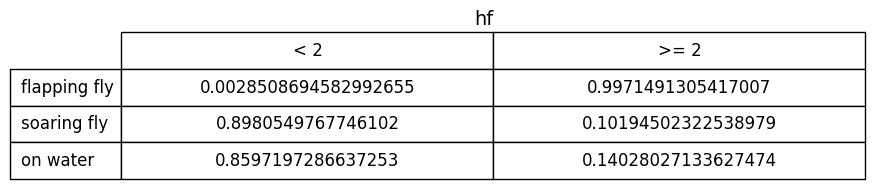

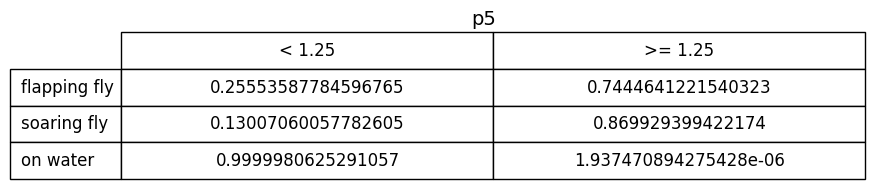

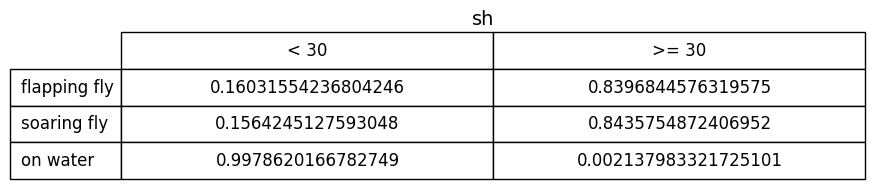

In [4]:
# Define the interval for hf.
low_interval = [0, 2]
high_interval = [2, float("inf")]

# Calculate probabilities of hf for each state in low and high interval
(
    prob_flapping_hf_l,
    prob_soaring_hf_l,
    prob_water_hf_l,
    prob_flapping_hf_h,
    prob_soaring_hf_h,
    prob_water_hf_h,
) = cal.cal_prob(low_interval, high_interval, hf)
vis.draw_table(
    "hf",
    "< 2",
    ">= 2",
    prob_flapping_hf_l,
    prob_soaring_hf_l,
    prob_water_hf_l,
    prob_flapping_hf_h,
    prob_soaring_hf_h,
    prob_water_hf_h,
)

# Define the interval for p5
low_interval = [0, 1.25]
high_interval = [1.25, float("inf")]

# Calculate probabilities of p5 for each state in low and high interval
(
    prob_flapping_p5_l,
    prob_soaring_p5_l,
    prob_water_p5_l,
    prob_flapping_p5_h,
    prob_soaring_p5_h,
    prob_water_p5_h,
) = cal.cal_prob(low_interval, high_interval, p5)
vis.draw_table(
    "p5",
    "< 1.25",
    ">= 1.25",
    prob_flapping_p5_l,
    prob_soaring_p5_l,
    prob_water_p5_l,
    prob_flapping_p5_h,
    prob_soaring_p5_h,
    prob_water_p5_h,
)

# Define the interval for sh
low_interval = [0, 30]
high_interval = [30, float("inf")]

# Calculate probabilities of sh for each state in low and high interval
(
    prob_flapping_sh_l,
    prob_soaring_sh_l,
    prob_water_sh_l,
    prob_flapping_sh_h,
    prob_soaring_sh_h,
    prob_water_sh_h,
) = cal.cal_prob(low_interval, high_interval, sh)
vis.draw_table(
    "sh",
    "< 30",
    ">= 30",
    prob_flapping_sh_l,
    prob_soaring_sh_l,
    prob_water_sh_l,
    prob_flapping_sh_h,
    prob_soaring_sh_h,
    prob_water_sh_h,
)

warnings.filterwarnings("default")

Now, let's define the **O** matrix, which stores observation probabilities based on the values in tables above. Unlike what you have learned from the lecture, our **O** is a **3 * 8 matrix**. Each row represents a state, and each column represents a possible observation. The first row which has the index 0 stands for "Flapping flight", the second row for "Soaring flight" and the third for the state "On water". 

The 8 columns are numbered from 0 to 7, which are called column IDs. The binary representation of the column ID indicates which possibility the column is about to store. For example, the column ID of the fourth column is 3, represented as "011" in binary. The first digit denotes whether the observation value of the feature "hf" is in the **low interval (0)** or **high interval (1)**. Similarly, the second digit  corresponds to the feature p5, and the third digit  corresponds to the feature sh. 

For example: O[1,3] stores the value Pr((hf < 2) & (p5 >= 1.25) & (sh >= 30) | Xt=Soaring flight)

In [5]:
# TODO: Implement the Observation matrix O
# NOTE: Matrix entry O_ij should store the value consistent with the discription above
# HINT1: You should use the variable defined in the last code block. 
#        Try to understand the meaning of prob_flapping_hf_l, prob_soaring_hf_h, etc.
# HINT2: Think about how combined probability can be calculated

O = np.zeros((3, 8), np.float32)


def define_sensor_model(O):
    """
    Create the sensor model based on the given data in the table above
    
    Args: 
        O: a 3*8 matrix to be modified

    Return:
        O: the sensor model which follows the description above

    """
    ##########################################################
    # YOUR CODE HERE:
    O[0, 0] = prob_flapping_hf_l * prob_flapping_p5_l * prob_flapping_sh_l
    O[0, 1] = prob_flapping_hf_l * prob_flapping_p5_l * prob_flapping_sh_h
    O[0, 2] = prob_flapping_hf_l * prob_flapping_p5_h * prob_flapping_sh_l
    O[0, 3] = prob_flapping_hf_l * prob_flapping_p5_h * prob_flapping_sh_h
    O[0, 4] = prob_flapping_hf_h * prob_flapping_p5_l * prob_flapping_sh_l
    O[0, 5] = prob_flapping_hf_h * prob_flapping_p5_l * prob_flapping_sh_h
    O[0, 6] = prob_flapping_hf_h * prob_flapping_p5_h * prob_flapping_sh_l
    O[0, 7] = prob_flapping_hf_h * prob_flapping_p5_h * prob_flapping_sh_h
    
    O[1, 0] = prob_soaring_hf_l * prob_soaring_p5_l * prob_soaring_sh_l
    O[1, 1] = prob_soaring_hf_l * prob_soaring_p5_l * prob_soaring_sh_h
    O[1, 2] = prob_soaring_hf_l * prob_soaring_p5_h * prob_soaring_sh_l
    O[1, 3] = prob_soaring_hf_l * prob_soaring_p5_h * prob_soaring_sh_h
    O[1, 4] = prob_soaring_hf_h * prob_soaring_p5_l * prob_soaring_sh_l
    O[1, 5] = prob_soaring_hf_h * prob_soaring_p5_l * prob_soaring_sh_h
    O[1, 6] = prob_soaring_hf_h * prob_soaring_p5_h * prob_soaring_sh_l
    O[1, 7] = prob_soaring_hf_h * prob_soaring_p5_h * prob_soaring_sh_h
    
    O[2, 0] = prob_water_hf_l * prob_water_p5_l * prob_water_sh_l
    O[2, 1] = prob_water_hf_l * prob_water_p5_l * prob_water_sh_h
    O[2, 2] = prob_water_hf_l * prob_water_p5_h * prob_water_sh_l
    O[2, 3] = prob_water_hf_l * prob_water_p5_h * prob_water_sh_h
    O[2, 4] = prob_water_hf_h * prob_water_p5_l * prob_water_sh_l
    O[2, 5] = prob_water_hf_h * prob_water_p5_l * prob_water_sh_h
    O[2, 6] = prob_water_hf_h * prob_water_p5_h * prob_water_sh_l
    O[2, 7] = prob_water_hf_h * prob_water_p5_h * prob_water_sh_h

    ##########################################################
    return O


O = define_sensor_model(O)
print("Observation Matrix:\n", O)

Observation Matrix:
 [[1.1678978e-04 6.1170966e-04 3.4024889e-04 1.7821211e-03 4.0849581e-02
  2.1395780e-01 1.1900892e-01 6.2333286e-01]
 [1.8272033e-02 9.8538518e-02 1.2220578e-01 6.5903866e-01 2.0741969e-03
  1.1185854e-02 1.3872503e-02 7.4812472e-02]
 [8.5788000e-01 1.8380629e-03 1.6621208e-06 3.5612002e-09 1.3998008e-01
  2.9991631e-04 2.7120785e-07 5.8108024e-10]]


If you are interested in how the data was obtained, please read [this paper](https://movementecologyjournal.biomedcentral.com/articles/10.1186/s40462-021-00243-z#MOESM3).

## 3. Initialization

Based on the statistics provided in the paper, we can assume that albatrosses spend 26.2% of their flight time on **flapping**, 36.3% on **soaring** and 37.5% **on water**. The initial probabilities of three states are given below. Please **DO NOT** change their value and the index order of the init_prob.

In [6]:
# Initial flying state probability parameters
pi0 = 0.262
pi1 = 0.363
pi2 = 0.375

# init_prob is a 3-dimensional vector
init_prob = np.array([pi0, pi1, pi2])

## 4. Build the HMM model

Now we would like to apply HMM to the real world. You should implement the **filtering, smoothing, prediction, and the Viterbi algorithm** based on the observation data step by step. Vectorized operations will be very useful during the implementation.

### 4.1. Preparation

Before implementing the algorithm, some preparatory works are necessary. The 10x3 matrix, **reading_seq**, provided below represents sensor readings at 10 timesteps. The first index represents the timestep, and the second index corresponds to the features mentioned (0 for hf, 1 for p5, and 2 for sh). For instance, reading_seq \[5\]\[2\] denotes the value at the sixth timestep corresponding to the sh feature. 

In [7]:
reading_seq = [
    [1.6, 0.8, 10],
    [1.9, 1.1, 18],
    [0.5, 0.9, 20],
    [1.9, 1.5, 35],
    [2.2, 1.0, 36],
    [2.3, 1.5, 40],
    [1.6, 1.5, 23],
    [3.0, 1.7, 17],
    [2.1, 1.2, 28],
    [1.0, 1.1, 20],
]

In [15]:
# TODO: Convert the sequence of sensors reading into an observation sequence
#       For example, if at a timestep, the hf value is larger equal than 2, p5 is smaller than 1.25,
#       and sh is larger equal than 30, the observation at this timestep should be '101' as a string.
# HINT: The method join() might be helpful.


def convert_reading_seq(sensor_reading_seq):
    """Convert the sequence of sensors reading into an observation sequence
    
    Args:
        sensor_reading_seq: a list with a shape of [T, 3], which stores the observation values of [hf, p5, sh].
                            T is the number of timesteps

    Return:
        observations: a list with a shape of [T], which stores 3-digit binary value strings corresponding to the description above 

    """
    observations = []
    ##########################################################
    # YOUR CODE HERE:
    sensor_reading_seq = np.array(sensor_reading_seq, dtype=np.float32)
    
    binary_reading_seq = np.zeros((10, 3), np.float32)
    
    for t in range(0, 10):
        if sensor_reading_seq[t, 0] >= 2:
            binary_reading_seq[t, 0] = 1
        if sensor_reading_seq[t, 1] >= 1.25:
            binary_reading_seq[t, 1] = 1
        if sensor_reading_seq[t, 2] >= 30:
            binary_reading_seq[t, 2] = 1
    
    observations = [''.join(map(str, map(int, row))) for row in binary_reading_seq]
                                          
    ##########################################################
    return observations

obs_seq = convert_reading_seq(reading_seq)
print(obs_seq)

['000', '000', '000', '011', '101', '111', '010', '110', '100', '000']


For the simplicity of calculating the observation matrix which will be introduced next, we defined the method create_obs_dict to index all observations. You may use the list **obs_dict** later.

In [8]:
def create_obs_dict():
    """
    create an observation dictionary which maps each observation into a integer value
    
    Args: None

    Return:
        observation_dict: a dictionary for all observation permutations

    """
    observation_dict = {}
    for idx, ob in enumerate(["000", "001", "010", "011", "100", "101", "110", "111"]):
        observation_dict[ob] = idx
    return observation_dict


obs_dict = create_obs_dict()
print(obs_dict)

{'000': 0, '001': 1, '010': 2, '011': 3, '100': 4, '101': 5, '110': 6, '111': 7}


For the observation at each timestep, which is stored in the **obs_seq** as a 3-digit binary value string, a corresponding observation matrix **O_matrix** should be constructed based on the given observation and the matrix **O** which you have implemented previously. This **O_matrix** is defined as same as what you have learned in the lecture, so it is a **3 * 3 diagonal matrix** which stores the probabilities of current observation under the condition that Xt=xi, i belongs to {0,1,2}, which refers to flapping flight, soaring flight, and on water respectively.

In [12]:
# TODO: Implement compute_observation_matrix
# NOTE: Matrix entry O_matrix[i,j] should store the value consistent with the discription above
# HINT: You may use the list "obs_dict" provided above


def compute_observation_matrix(observation):
    """Compute the observation matrix for vectorized operation.

    Args:
        observation: a 3-digit binary value string described the observation at a certain timestep,
                     has the same form as elements in the obs_seq. e.g.'010'

    Return:
        O_matrix: observation matrix at this timestep given the observation

    """
    # define the observation matrix given an observation in some timestep
    O_matrix = np.zeros((3, 3), np.float32)

    ###########################################################################
    # YOUR CODE HERE
    O_matrix[0, 0] = O[0, obs_dict[observation]]
    O_matrix[1, 1] = O[1, obs_dict[observation]]
    O_matrix[2, 2] = O[2, obs_dict[observation]]

    ###########################################################################

    return O_matrix

With all the preparatory work completed, it's time to move on to implementing key algorithms for the Hidden Markov Model (HMM)!

### 4.2. Filtering

To implement the **"Filtering"** algorithm, you should firstly implement **forward_onestep** method. As we learned in the lecture, "Filtering" means that the current state depends on the past and current observations.

In [13]:
# TODO: Compute one step forward based on the observation, transition matrix and current probability of states
# HINT1: You have already implemented the transition matrix above
# HINT2: You don't need to implement normalization here.


def forward_onestep(f, observation):
    """Compute one forward step for filtering.
       Hint: Use the O_matrix we provided for one step forward opration.
       N stands for the number of states
       
    Args:
        f: numpy array with shape [N], the probability distribution at the timestep t
        observation: a 3-digit binary value string representing the observed state at the timestep t+1

    Return:
        f_onestep: numpy array with shape [N], the possibility distrubution at the timestep t+1 without normalization

    """
    # Acquire the row vector and transform it to diagonal matrix
    f_onestep = None

    ##########################################################
    # YOUR CODE HERE
    O_matrix = compute_observation_matrix(observation)
    f_onestep = np.dot(np.dot(O_matrix, Trans), f) 

    ##########################################################

    return f_onestep

By iterating over all past states, we get the following results.

Movement modalities estimation using Filtering algorithm:
[[8.41895810e-05 2.13962446e-02 9.78519566e-01]
 [1.65880770e-06 7.79697082e-04 9.99218644e-01]
 [1.40641527e-06 3.65107485e-04 9.99633486e-01]
 [1.65846965e-03 9.98341209e-01 3.21785513e-07]
 [6.41560288e-01 3.58258018e-01 1.81694195e-04]
 [9.06722462e-01 9.32775382e-02 2.84732601e-11]
 [7.32957902e-03 9.92669522e-01 8.99014394e-07]
 [4.57846348e-01 5.42153450e-01 2.01443996e-07]
 [8.17871805e-01 6.01745036e-02 1.21953692e-01]
 [6.27644912e-04 3.40742356e-02 9.65298120e-01]]


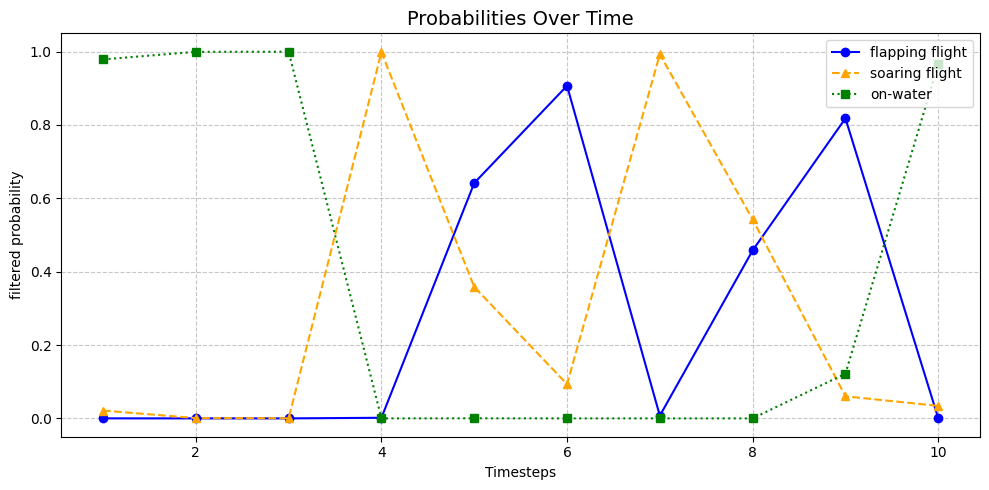

In [16]:
forward_prob = []
forward_prob.append(init_prob)
for i in range(len(obs_seq)):
    unnormalized = forward_onestep(forward_prob[-1], obs_seq[i])
    if unnormalized is not None:
        forward_prob.append(unnormalized / np.sum(unnormalized, axis=0))

if len(forward_prob) > 1:
    forward_prob.pop(0)
    filtered_prob = np.array(forward_prob)
    print("Movement modalities estimation using Filtering algorithm:")
    print(filtered_prob)
    vis.visualize_probability(obs_seq, "filtered probability", filtered_prob)
else:
    print("The definition of your HMM is incomplete!")

### 4.3. Smoothing

As we learned in the lecture, Smoothing also takes future observations into consideration, which can improve our estimation of past hidden states. Use the following code to visualize the difference between Filtering and Smoothing.

In [19]:
# TODO: Compute one step backward based on the observation, transition matrix and current probability of states
# HINT: You may take a look at how forward_onestep is implemented
# HINT2: You don't need to implement normalization here.

def backward_onestep(b, observation):
    """Compute one backward step for smoothing
       Hint: Use the O_matrix we provided for one step backward.
       N stands for the number of states
       
    Args:
        b: numpy array with shape [N], the probability distribution at the timestep t+2
        observation: observed state in timestep t+1

    Return:
        b_onestep: numpy array with shape [N], the possibility distrubution at the timestep t+1 without normalization

    """

    b_onestep = None

    ##########################################################
    # YOUR CODE HERE
    O_matrix = compute_observation_matrix(observation)
    Trans_tr = np.transpose(Trans)
    b_onestep = np.dot(np.dot(Trans_tr, O_matrix), b) 

    ##########################################################

    return b_onestep

In [22]:
# TODO: Implement the forward_backward algorithm for smoothing according to the lecture
# HINT: We provided you the way to implement the normalization, you may take a a look at this.


def forward_backward(observation_sequence):
    """forward-backward algorithm for smoothing
        In this function, you will finalize the forward-backward algorithm based
        on your previous implementations of function “forward_onestep” and
        "backward_onestep".

        Remember to normalize the result smoothed probability to ensure the
        probability sum to be 1!

        T stands for sequence length and N stands for number of hidden states.

    Args:
        observation_sequence: observed sequence in a given period with length T


    Return:
        smoothed_prob: numpy array with shape [T, N], state probability in this
                       period after smoothing.

    """
    forward_prob = []
    smoothed_prob = []
    backward_prob = []
    T = len(observation_sequence)
    N_state = len(Trans)

    ##########################################################
    # YOUR CODE HERE
    forward_prob.append(init_prob)
    for i in range(T):
        unnormalized_f = forward_onestep(forward_prob[-1], observation_sequence[i])
        forward_prob.append(unnormalized_f)
    forward_prob.pop(0)
    
    backward_prob = [np.zeros(N_state)] * T 
    backward_prob[T - 1] = np.ones(N_state)
    for i in range (T-1, 0, -1):
        unnormalized_b = backward_onestep(backward_prob[i],observation_sequence[i])
        backward_prob[i-1] = unnormalized_b
        
    for i in range (T):
        unnormalized = np.multiply(forward_prob[i], backward_prob[i])
        if unnormalized is not None:
            smoothed_prob.append(unnormalized / np.sum(unnormalized, axis=0))
    
    ##########################################################

    return np.array(smoothed_prob)

Movement modalities estimation using Smoothing algorithm:
[[2.00923102e-06 8.50711820e-04 9.99147279e-01]
 [4.36628769e-07 8.51589416e-04 9.99147974e-01]
 [1.86328857e-05 1.99335175e-02 9.80047850e-01]
 [1.15354476e-02 9.88464522e-01 3.00640825e-08]
 [7.46108103e-01 2.53887563e-01 4.33397549e-06]
 [6.98249135e-01 3.01750865e-01 1.64938468e-12]
 [3.45868211e-02 9.65413117e-01 6.14453771e-08]
 [5.21976473e-01 4.78013944e-01 9.58315155e-06]
 [1.31755767e-01 1.56220017e-02 8.52622231e-01]
 [6.27644912e-04 3.40742356e-02 9.65298120e-01]]


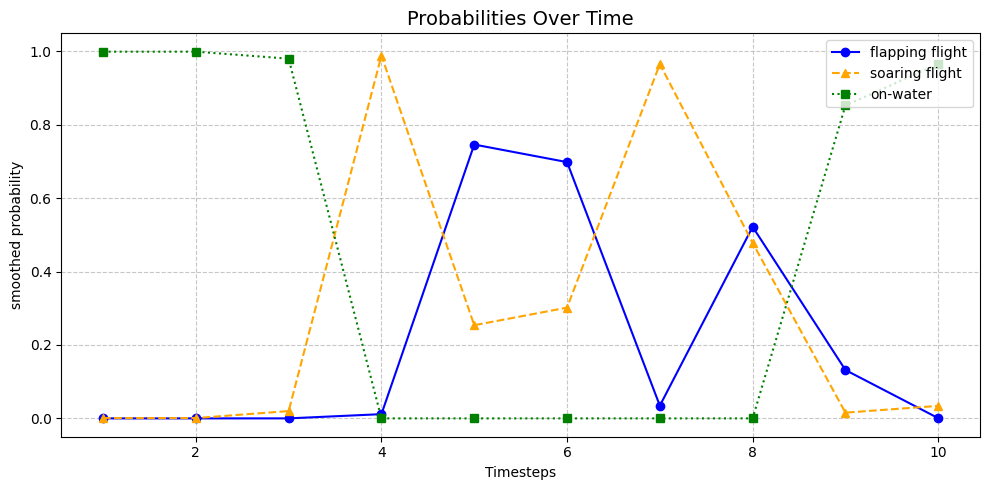

In [23]:
smoothed_prob = forward_backward(obs_seq)
if len(smoothed_prob) != 0:
    print("Movement modalities estimation using Smoothing algorithm:")
    print(smoothed_prob)
    vis.visualize_probability(obs_seq, "smoothed probability", smoothed_prob)
else:
    print("The definition of your HMM is incomplete!")

### 4.4. Prediction

 Based on some past observations, we can use the HMM model to predict the hidden state in the near future. However, it is not very accurate for predicting the state over a long time span.

In [24]:
# TODO: Compute the pred_history based on the filtering result
# HINT: Get the filtering result at the last timestep firstly, then perform the prediction


def predict(observation_sequence, k):
    """Predict state probability for future timesteps, remember to filter the given observation sequence.

        Remember to normalize the resulting forward probability to ensure
        that the probability sums to 1.

        N stands for number of hidden states.

    Args:
        observation_sequence: observed sequence in a given period with length T
        k: the number of steps of timestep T

    Return:
        pred_history: numpy array with shape[k, N], state probability of all k
                      timesteps in the future

    """

    pred_history = []

    ##########################################################
    # YOUR CODE HERE
    forward_prob = init_prob
    T = len(observation_sequence)
    for i in range(T):
        unnormalized = forward_onestep(forward_prob, observation_sequence[i])
        forward_prob = unnormalized / np.sum(unnormalized, axis=0)

    pred_history.append(forward_prob)
    for i in range(k):
        unnormalized = Trans.dot(pred_history[-1])
        if unnormalized is not None:
            pred_history.append(unnormalized / np.sum(unnormalized, axis=0))
    pred_history.pop(0)

    ##########################################################

    return np.array(pred_history)

In [25]:
# predict 3 timesteps probability distribution after the observation sequence

obs_seq2 = ["101", "111", "111", "011", "101"]
hidden_state_sequence2 = predict(obs_seq2, 3)
if len(hidden_state_sequence2) != 0:
    print(hidden_state_sequence2)
else:
    print("The definition of your HMM is incomplete!")

[[0.53884316 0.44333301 0.01782383]
 [0.45619486 0.50920889 0.03459624]
 [0.39752991 0.55190529 0.0505648 ]]


### 4.5. Viterbi algorithm

 Using the forward-backward algorithm, we can calculate the probability distribution of states at different timesteps. Then, we can find the hidden state sequence that most likely explains the observation sequence using the Viterbi Algorithm.

In [29]:
# TODO: Implement viterbi algorithm


def viterbi(observation_sequence):
    """Compute the most likely state trajectory given a observation sequence.
        T stands for sequence length.

    Args:
        observation_sequence: observed sequence in a given period with length T

    Return:
        trajectory: list of length T, representing the trajectory of the most
                    likely state in the given period. Note that the output
                    trajectory is in the form of the corresponding indices of
                    the states. For example, an output of [2, 1, 0] indicates
                    that, given a sequence of length T=3, the most likely state
                    transforms from state 2 to state 1 and finally to state 0.
    """

    trajectory = []
    T = len(observation_sequence)

    ##########################################################
    # YOUR CODE HERE
    N_state = len(Trans)
    ev = observation_sequence.copy()
    ev.insert(0, None)

    inter = [np.zeros(N_state)] * T
    inter[0] = forward_onestep(init_prob, ev[1])
    backtracking_graph = []
    for i in range(1, T):
        inter[i] = (np.max(compute_observation_matrix(ev[i + 1]), axis=0) * [np.max(Trans[0] * inter[i - 1]), np.max(Trans[1] * inter[i - 1]), np.max(Trans[2] * inter[i - 1])]).tolist()
        backtracking_graph.append([np.argmax(Trans[0] * inter[i - 1]),
                                   np.argmax(Trans[1] * inter[i - 1]),
                                   np.argmax(Trans[2] * inter[i - 1])])

    trajectory = [0] * T
    i_max = np.argmax(inter[-1])

    for i in range(T - 1, -1, -1):
        trajectory[i] = i_max
        if i > 0:
            i_max = backtracking_graph[i - 1][i_max]

    ###########################################################

    return trajectory

In [30]:
# TODO: Apply veterbi algorithm to the observation sequence "obs_seq"
hidden_state_sequence = []

##########################################################
# YOUR CODE HERE
hidden_state_sequence = viterbi(obs_seq)

##########################################################

print(hidden_state_sequence)

[2, 2, 2, 1, 0, 0, 1, 1, 2, 2]


 In the lecture, we also learned that the most likely sequence is not necessarily the same as the sequence of most likely states. By running the following code for visualization, you can compare the results of the two and see if they are the same.

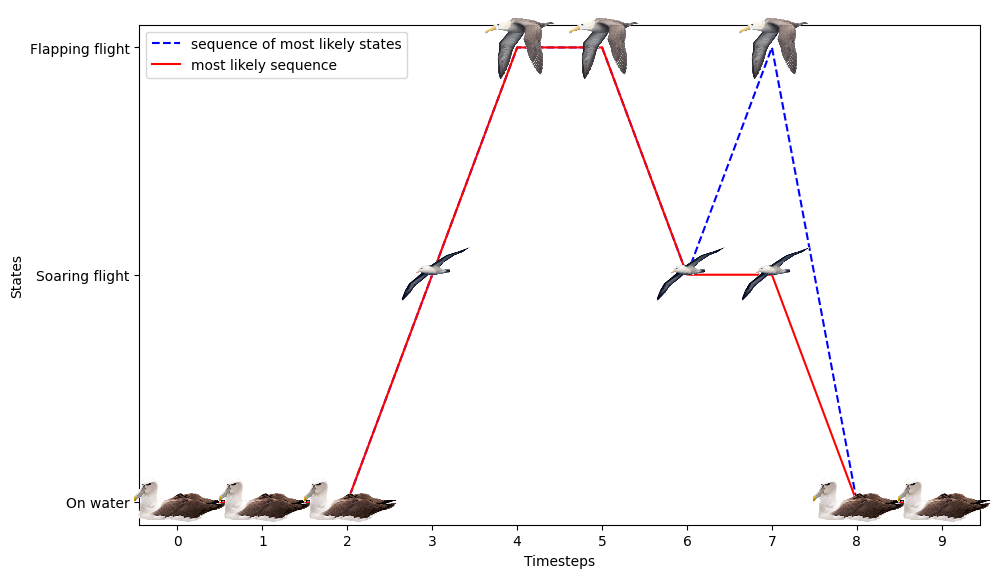

In [31]:
# calculate the sequence of most likely states
sequence_of_most_likely_states = []

if len(smoothed_prob) != 0:
    sequence_of_most_likely_states = np.argmax(smoothed_prob, axis=1).tolist()
    # Visualizing the difference between the most likely sequence and the sequence of most likely states
    vis.vis_traj(
        [sequence_of_most_likely_states, hidden_state_sequence],
        ["blue", "red"],
        ["--", "-"],
        ["sequence of most likely states", "most likely sequence"],
    )

else:
    print("The definition of your HMM is incomplete!")

## 5. Summary

**Congratulation!** You have now successfully implemented a research project.

In this programming exercise, you implemented an HMM model to estimate an animal's behavior based on an observation sequence. We hope you have a better understanding of the **Filtering**, **Smoothing**, and **Viterbi algorithm**, and have gained some practical experience about the **Hidden Markov Model**.

In the real world, animals' behaviors are also based on numerous external factors, such as environmental changes, seasonal variations, and the availability of resources. These external influences play a crucial role in shaping and modulating animal behavior. Animals often adapt their actions in response to alterations in their surroundings, demonstrating a remarkable ability to navigate and thrive in dynamic ecosystems.